Mounting to drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


copy .py files from drive so we can use it

In [ ]:
!cp /content/drive/MyDrive/Sozana/yolo_utils.py /content

In [ ]:
!cp /content/drive/MyDrive/Sozana/setup_sets.py /content

copy dataset from drive and unzip it 

In [ ]:
import shutil
shutil.copyfile('drive/MyDrive/Traffic.Road.Signs.YoloV3.format.v2-10-01-2021.darknet.zip', 'Traffic.Road.Signs.zip')

'Traffic.Road.Signs.zip'

In [ ]:
shutil.unpack_archive('Traffic.Road.Signs.zip','Traffic.Road.Signs')

check openCV version,

 if not 4.5.5 make it 4.5.5 !!

In [ ]:
print('OpenCV version : ', cv2. __version__)
print(cv2.cuda.getCudaEnabledDeviceCount())

In [ ]:
pip install opencv-python==4.5.5.62 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import useful libraries
import os
import numpy as np
import cv2
from yolo_utils import *

OpenCV version :  4.5.5
0


execute setup_sets to prepare dataset for our pretrained model

In [ ]:
!python /content/setup_sets.py


 Start Processing!

 Processing complete!


### Load YoloV4 labels

In [ ]:
# test our function read_classes to make sure it consider all road sign that we want
img_file = '/content/Traffic.Road.Signs/data/obj.names'
classNames = read_classes(img_file)
print("Classes' names :\n", classNames)

Classes' names :
 ['crosswalk', 'speedlimit', 'stop', 'trafficlight']


In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=27a2ef169c42b89b30038b6caa789fa3c33ac43f70b86b5a1418005751c0c7e9
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
# download yolo4 weights from github and move it to specific path 
import wget
url ="https://github.com/fredotran/traffic-signs-detection/releases/download/weights/yolov4-rds_best_2000.weights"
path = '/content/drive/MyDrive/traffic-sign-detector-yolov4-main/weights'
wget.download(url, path)

'/content/drive/MyDrive/traffic-sign-detector-yolov4-main/weights/yolov4-rds_best_2000 (1).weights'

In [ ]:
# load the model config and weights
modelConfig_path = '/content/drive/MyDrive/traffic-sign-detector-yolov4-main/cfg/yolov4-rds.cfg'
# modelWeights_path = './weights/yolov4-rds_last.weights'
modelWeights_path = '/content/drive/MyDrive/traffic-sign-detector-yolov4-main/weights/yolov4-rds_best_2000.weights'
# read the model cfg and weights with the cv2 DNN module
neural_net = cv2.dnn.readNetFromDarknet(modelConfig_path, modelWeights_path)
# set the preferable Backend to GPU
neural_net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
neural_net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

convert_to_blob and box_drawing functions are used to detect road sign and draw box around it



In [ ]:
def convert_to_blob(input_frame, network, height, width):
    """ This function allow us to convert a frame/image into blob format for OpenCV DNN"""    
    blob = cv2.dnn.blobFromImage(input_frame, 1/255, (height,width), [0,0,0], 1, crop=False)
    network.setInput(blob)
    # get the YOLO output layers numbers (names), these layers will be useful for the detection part
    # the layer's name : yolo_82, yolo_94, yolo_106
    yoloLayers = network.getLayerNames()
    yoloLayers = [(yoloLayers[i -1]) for i in network.getUnconnectedOutLayers()]
    # Doing forward propagation with OpenCV
    outputs = network.forward(yoloLayers)
    
    return outputs

In [ ]:
def box_drawing(input_frame, indices, bounding_boxes, class_objects, confidence_probs, classNames, color=(0,255,255), thickness=2):
    """ Drawing the detected objects boxes """
    # once we have the indices, we'll extract the values of x,y,w,h of the best bounding boxes and store them.
    for i in indices:
        # i = i[0]
        final_box = bounding_boxes[i]
    # we'll retrieve the bounding boxes values (coordinates) now and use them to draw our boxes.
        x, y, w, h = final_box[0], final_box[1], final_box[2], final_box[3]
        x, y, w, h = int(x), int(y), int(w), int(h)        
        print('Bounding box coordinates in the frame : ', 'x : ', x,'|| y : ',y,'|| w : ',w,'|| h :',h , '\n')
    
        cv2.rectangle(input_frame, (x,y), (x+w,y+h),  color, thickness)
        cv2.putText(input_frame, f'{classNames[class_objects[i]].upper()} {int(confidence_probs[i]*100)}%',
                        (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,  color, thickness=1)

### Test on image files



In [ ]:
# defining the input frame resolution for the neural network to process
network = neural_net
height, width = 416,416

# confidence and non-max suppression threshold for this YoloV3 version
confidenceThreshold = 0.5
nmsThreshold = 0.2

# load the image
img = cv2.imread('/content/drive/MyDrive/traffic-sign-detector-yolov4-main/inputs/images/speed-limit/speed-limit1.jpg')

# using convert_to_blob function : 
outputs = convert_to_blob(img, network, height, width)    
# apply object detection on the video file
bounding_boxes, class_objects, confidence_probs = object_detection(outputs, img, confidenceThreshold)   
# perform non-max suppression 
indices = nms_bbox(bounding_boxes, confidence_probs, confidenceThreshold, nmsThreshold)
# draw the boxes
box_drawing(img, indices, bounding_boxes, class_objects, confidence_probs, classNames, color=(255,0,0), thickness=2)

# to save the detected image
img_save = cv2.imwrite('/content/drive/MyDrive/traffic-sign-detector-yolov4-main/results/k.jpg', img)

# cv2.imshow('Object detection in images', img)
# cv2.waitKey()
# cv2.destroyAllWindows()

Number of objects detected :  1 

Bounding box coordinates in the frame :  x :  59 || y :  36 || w :  185 || h : 222 



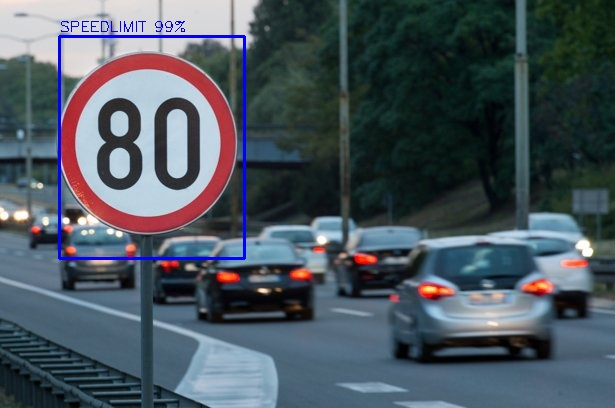

In [ ]:
from IPython.display import display, Image

# display our saved imgs
display(Image(filename='/content/drive/MyDrive/traffic-sign-detector-yolov4-main/results/k.jpg'))
